# Projet 3 - Anticipez les besoins en consommation de bâtiments

## Notebook d'explorations de modèles pour la prédiction de la consommation d'énergie SiteEnergyUse(kBtu)

Le but de ce notebook est d'utiliser le dataset df_SEU que nous avons créer à l'étape précédente et de créer des modèles prédictifs pour les consommations énergétiques.

In [1]:
import pandas as pd
from MLUtils import DataAnalysis

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importation du jeu de données
df = pd.read_csv('data/clean.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2524 entries, 0 to 2523
Data columns (total 41 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   NumberofBuildings                          2524 non-null   float64
 1   NumberofFloors                             2524 non-null   float64
 2   PropertyGFATotal                           2524 non-null   int64  
 3   PropertyGFAParking                         2524 non-null   int64  
 4   PropertyGFABuilding(s)                     2524 non-null   int64  
 5   LargestPropertyUseTypeGFA                  2524 non-null   float64
 6   ENERGYSTARScore                            2524 non-null   float64
 7   SiteEUI(kBtu/sf)                           2524 non-null   float64
 8   SiteEUIWN(kBtu/sf)                         2524 non-null   float64
 9   SourceEUI(kBtu/sf)                         2524 non-null   float64
 10  SourceEUIWN(kBtu/sf)    

In [4]:
from sklearn.model_selection import train_test_split

# Supposons que votre DataFrame s'appelle df
X = df.drop('SiteEnergyUse(kBtu)', axis=1)  # Features
y = df['SiteEnergyUse(kBtu)']  # Target

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 1) Modèle linéaire simple (régression linéaire)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Régression linéaire ne nécessite pas vraiment de GridSearch car il n'y a pas d'hyperparamètres complexes
# Mais pour la démonstration, on va juste l'utiliser directement
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


LinearRegression()

In [6]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Création d'un DummyRegressor
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_dummy = dummy_regressor.predict(X_test)

# Évaluation du DummyRegressor
rmse_dummy = mean_squared_error(y_test, y_pred_dummy, squared=False)
r2_dummy = r2_score(y_test, y_pred_dummy)

print(f"Dummy RMSE: {rmse_dummy}")
print(f"Dummy R^2: {r2_dummy}")


Dummy RMSE: 14584322.704543293
Dummy R^2: -8.89027014554511e-05


## 2) Modèle Random Forest Regressor (GridsearchCV)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(random_state=42)

param_grid_rfr = {
    'n_estimators': [30,40,50],
    'max_depth': [7,8,9],
    'max_features': [7, 8, 9]
}

grid_search_rfr = GridSearchCV(estimator=model_rfr, param_grid=param_grid_rfr, cv=3, n_jobs=-1, verbose=2)

grid_search_rfr.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .......max_depth=7, max_features=7, n_estimators=30; total time=   0.1s
[CV] END .......max_depth=7, max_features=7, n_estimators=30; total time=   0.1s
[CV] END .......max_depth=7, max_features=7, n_estimators=50; total time=   0.1s
[CV] END .......max_depth=7, max_features=8, n_estimators=30; total time=   0.1s
[CV] END .......max_depth=7, max_features=7, n_estimators=50; total time=   0.1s
[CV] END .......max_depth=7, max_features=7, n_estimators=40; total time=   0.1s
[CV] END .......max_depth=7, max_features=8, n_estimators=30; total time=   0.1s
[CV] END .......max_depth=7, max_features=7, n_estimators=40; total time=   0.1s
[CV] END .......max_depth=7, max_features=8, n_estimators=30; total time=   0.1s
[CV] END .......max_depth=7, max_features=7, n_estimators=30; total time=   0.1s
[CV] END .......max_depth=7, max_features=8, n_estimators=40; total time=   0.1s
[CV] END .......max_depth=7, max_features=8, n_e

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9], 'max_features': [7, 8, 9],
                         'n_estimators': [30, 40, 50]},
             verbose=2)

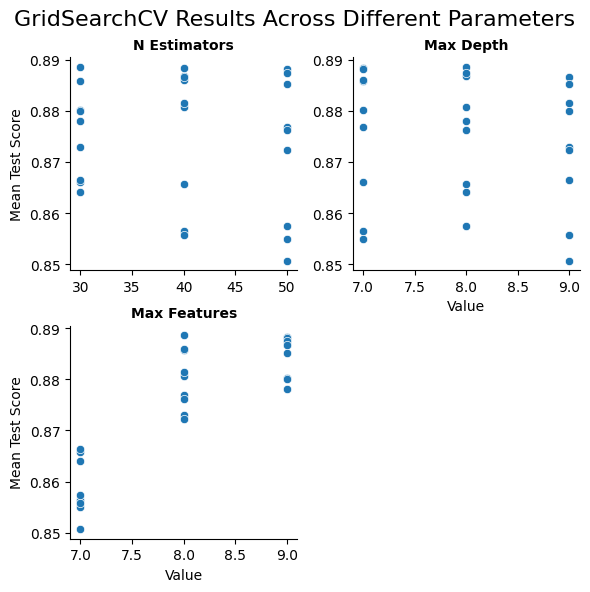

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the grid_search_gbr.cv_results_ to a DataFrame
results = pd.DataFrame(grid_search_rfr.cv_results_)

# Select and rename columns for easier reading
results = results[['param_n_estimators', 'param_max_depth', 'param_max_features', 'mean_test_score']]
results.columns = ['N Estimators', 'Max Depth', 'Max Features', 'Mean Test Score']

# Melt the DataFrame for easier plotting
results_melted = results.melt(id_vars='Mean Test Score', var_name='Parameter', value_name='Value')

# Create the FacetGrid
g = sns.FacetGrid(results_melted, col='Parameter', sharex=False, sharey=False, col_wrap=2)
g = g.map(sns.scatterplot, 'Value', 'Mean Test Score')

# Add titles and adjust layout
g.set_titles(col_template="{col_name}", fontweight='bold', fontsize=14)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('GridSearchCV Results Across Different Parameters', fontsize=16)

plt.show()


In [9]:
import pandas as pd
import plotly.graph_objects as go

# Assuming that grid_search.cv_results_ is defined elsewhere and contains the grid search results
cv_results = pd.DataFrame(grid_search_rfr.cv_results_)

cv_results['param_n_estimators'] = cv_results['param_n_estimators'].astype(int)
cv_results['param_max_features'] = cv_results['param_max_features'].astype(int)

pivot_df = cv_results.pivot_table(index='param_n_estimators', columns='param_max_features', values='mean_test_score')

pivot_df.index = pivot_df.index.astype(str)
pivot_df.columns = pivot_df.columns.astype(str)

# Create a new DataFrame to hold the percentage format text
text = [[f"{val:.2%}" for val in row] for row in pivot_df.values]

fig = go.Figure(data=go.Heatmap(
    z=pivot_df.values,
    x=pivot_df.columns.tolist(),
    y=pivot_df.index.tolist(),
    colorscale='RdYlGn',
    reversescale=False,
    text=text,  # Add the percentage text
    texttemplate="%{text}",  # Use the text from the text argument
    hoverinfo="z+text"  # Show the percentage text on hover
))

fig.update_layout(
    title='Grid Search Results',
    xaxis_title='max_features',
    yaxis_title='n_estimators',
    height=500
)

fig.show()


In [10]:
import pandas as pd
import plotly.graph_objects as go

# Assuming that grid_search.cv_results_ is defined elsewhere and contains the grid search results
cv_results = pd.DataFrame(grid_search_rfr.cv_results_)

cv_results['param_n_estimators'] = cv_results['param_n_estimators'].astype(int)
cv_results['param_max_depth'] = cv_results['param_max_depth'].astype(int)

pivot_df = cv_results.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

pivot_df.index = pivot_df.index.astype(str)
pivot_df.columns = pivot_df.columns.astype(str)

# Create a new DataFrame to hold the percentage format text
text = [[f"{val:.2%}" for val in row] for row in pivot_df.values]

fig = go.Figure(data=go.Heatmap(
    z=pivot_df.values,
    x=pivot_df.columns.tolist(),
    y=pivot_df.index.tolist(),
    colorscale='RdYlGn',
    reversescale=False,
    text=text,  # Add the percentage text
    texttemplate="%{text}",  # Use the text from the text argument
    hoverinfo="z+text"  # Show the percentage text on hover
))

fig.update_layout(
    title='Grid Search Results',
    xaxis_title='param_max_depth',
    yaxis_title='n_estimators',
    height=500
)

fig.show()


In [11]:
import pandas as pd
import plotly.graph_objects as go

# Assuming that grid_search.cv_results_ is defined elsewhere and contains the grid search results
cv_results = pd.DataFrame(grid_search_rfr.cv_results_)

cv_results['param_max_features'] = cv_results['param_max_features'].astype(int)
cv_results['param_max_depth'] = cv_results['param_max_depth'].astype(int)

pivot_df = cv_results.pivot_table(index='param_max_features', columns='param_max_depth', values='mean_test_score')

pivot_df.index = pivot_df.index.astype(str)
pivot_df.columns = pivot_df.columns.astype(str)

# Create a new DataFrame to hold the percentage format text
text = [[f"{val:.2%}" for val in row] for row in pivot_df.values]

fig = go.Figure(data=go.Heatmap(
    z=pivot_df.values,
    x=pivot_df.columns.tolist(),
    y=pivot_df.index.tolist(),
    colorscale='RdYlGn',
    reversescale=False,
    text=text,  # Add the percentage text
    texttemplate="%{text}",  # Use the text from the text argument
    hoverinfo="z+text"  # Show the percentage text on hover
))

fig.update_layout(
    title='Grid Search Results',
    xaxis_title='param_max_features',
    yaxis_title='param_max_depth',
    height=500
)

fig.show()


In [12]:
from sklearn.ensemble import GradientBoostingRegressor

model_gbr = GradientBoostingRegressor(random_state=42)

# New parameter grid for GradientBoostingRegressor
param_grid_gbr = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search_gbr = GridSearchCV(estimator=model_gbr, param_grid=param_grid_gbr, cv=3, n_jobs=-1, verbose=2)

# Training the model
grid_search_gbr.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, n_estimators=150; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=log2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, n_estimators=150; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, max_features=s

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

In [13]:
import plotly.express as px
import pandas as pd

# Convert the grid_search_gbr.cv_results_ to a DataFrame
results = pd.DataFrame(grid_search_gbr.cv_results_)

# Filter the columns for plotting
plot_data = results.filter(regex='(param_n_estimators|param_learning_rate|mean_test_score)')

# Rename columns for easier reading
plot_data.rename(columns={
    'param_n_estimators': 'N Estimators',
    'param_learning_rate': 'Learning Rate',
    'mean_test_score': 'Mean Test Score'
}, inplace=True)

# Create a 3D scatter plot
fig = px.scatter_3d(
    plot_data, 
    x='N Estimators', 
    y='Learning Rate', 
    z='Mean Test Score', 
    color='Mean Test Score', 
    title='GridSearchCV Results'
)

fig.show()


In [14]:
# show which is the best model
print(grid_search_rfr.best_estimator_)

RandomForestRegressor(max_depth=8, max_features=8, n_estimators=30,
                      random_state=42)


In [15]:
# show which is the best model
print(grid_search_gbr.best_estimator_)

GradientBoostingRegressor(max_depth=4, max_features='log2', n_estimators=200,
                          random_state=42)


In [16]:
# show the comparison as a table for each model
results_rfr = pd.DataFrame(grid_search_rfr.cv_results_)
results_gbr = pd.DataFrame(grid_search_gbr.cv_results_)
results_rfr = results_rfr[['param_n_estimators', 'param_max_depth', 'param_max_features', 'mean_test_score']]
results_gbr = results_gbr[['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_max_features', 'mean_test_score']]

# order by mean_test_score descending
results_rfr = results_rfr.sort_values(by='mean_test_score', ascending=False)
results_gbr = results_gbr.sort_values(by='mean_test_score', ascending=False)



In [17]:
print(results_rfr)


    param_n_estimators  param_max_depth  param_max_features  mean_test_score
12                  30                8                   8         0.888625
7                   40                7                   9         0.888364
8                   50                7                   9         0.888156
17                  50                8                   9         0.887486
16                  40                8                   9         0.886763
25                  40                9                   9         0.886641
4                   40                7                   8         0.885995
3                   30                7                   8         0.885775
26                  50                9                   9         0.885152
22                  40                9                   8         0.881523
13                  40                8                   8         0.880721
6                   30                7                   9         0.880231

In [18]:
print(results_gbr)

    param_n_estimators  param_learning_rate  param_max_depth  \
29                 200                 0.10                4   
28                 150                 0.10                4   
27                 100                 0.10                4   
42                 100                 0.20                4   
44                 200                 0.20                4   
43                 150                 0.20                4   
26                 200                 0.10                4   
25                 150                 0.10                4   
24                 100                 0.10                4   
23                 200                 0.10                3   
22                 150                 0.10                3   
21                 100                 0.10                3   
41                 200                 0.20                3   
40                 150                 0.20                3   
39                 100                 0

In [19]:
import plotly.express as px

# Assurez-vous que results_rfr est déjà trié par mean_test_score en ordre descendant
# Si ce n'est pas le cas, décommentez la ligne suivante
# results_rfr = results_rfr.sort_values(by='mean_test_score', ascending=False)

# Création d'une colonne 'params' pour afficher la combinaison des paramètres dans le graphique
results_rfr['params'] = 'Estimators: ' + results_rfr['param_n_estimators'].astype(str) + ', Depth: ' + results_rfr['param_max_depth'].astype(str) + ', Features: ' + results_rfr['param_max_features'].astype(str)

# Création du graphique à barres
fig = px.bar(results_rfr, 
             x='params', 
             y='mean_test_score',
             labels={'params': 'Paramètres', 'mean_test_score': 'Score moyen du test'},
             title="Scores moyens du test pour différentes configurations du RFR")

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()


In [20]:
import plotly.express as px

# Assurez-vous que les données sont déjà triées par mean_test_score en ordre descendant
# Si ce n'est pas le cas, triez-les à nouveau pour être sûr
results_gbr = results_gbr.sort_values(by='mean_test_score', ascending=False)

# Création d'une colonne 'params' pour afficher la combinaison des paramètres dans le graphique
results_gbr['params'] = 'Estimators: ' + results_gbr['param_n_estimators'].astype(str) + \
                        ', LR: ' + results_gbr['param_learning_rate'].astype(str) + \
                        ', Depth: ' + results_gbr['param_max_depth'].astype(str) + \
                        ', Features: ' + results_gbr['param_max_features'].astype(str)

# Création du graphique à barres
fig = px.bar(results_gbr, 
             x='params', 
             y='mean_test_score',
             labels={'params': 'Paramètres', 'mean_test_score': 'Score moyen du test'},
             title="Scores moyens du test pour différentes configurations du GBR")

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()


In [21]:
from sklearn.metrics import mean_squared_error

# Prédictions avec la régression linéaire
y_pred_linear = linear_model.predict(X_test)

# Prédictions avec le meilleur modèle RandomForest trouvé par GridSearchCV
y_pred_rf = grid_search_rfr.best_estimator_.predict(X_test)

# Calcul de la RMSE pour chaque modèle
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

print(f"RMSE Régression Linéaire: {rmse_linear}")
print(f"RMSE RandomForest: {rmse_rf}")


RMSE Régression Linéaire: 511569.26811664324
RMSE RandomForest: 3838014.677537578


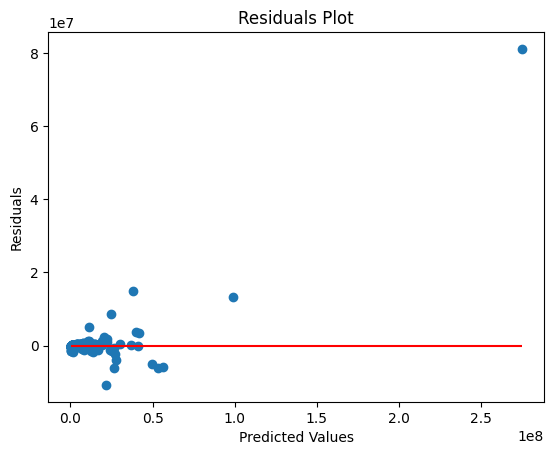

In [22]:
# Calcul des résidus
residuals = y_test - y_pred_rf

# Visualisation des résidus
plt.scatter(y_test, residuals)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()


Après avoir évalué plusieurs modèles, le GradientBoostingRegressor avec n_estimators=200, LR=0.1, features=sqrt et max_depth=3 a été choisi pour sa supériorité en termes de performance par rapport au modèle de référence et à la régression linéaire, tout en conservant une complexité raisonnable. Bien que le temps de calcul soit plus élevé, l'amélioration significative de la RMSE et du R² justifie ce choix.

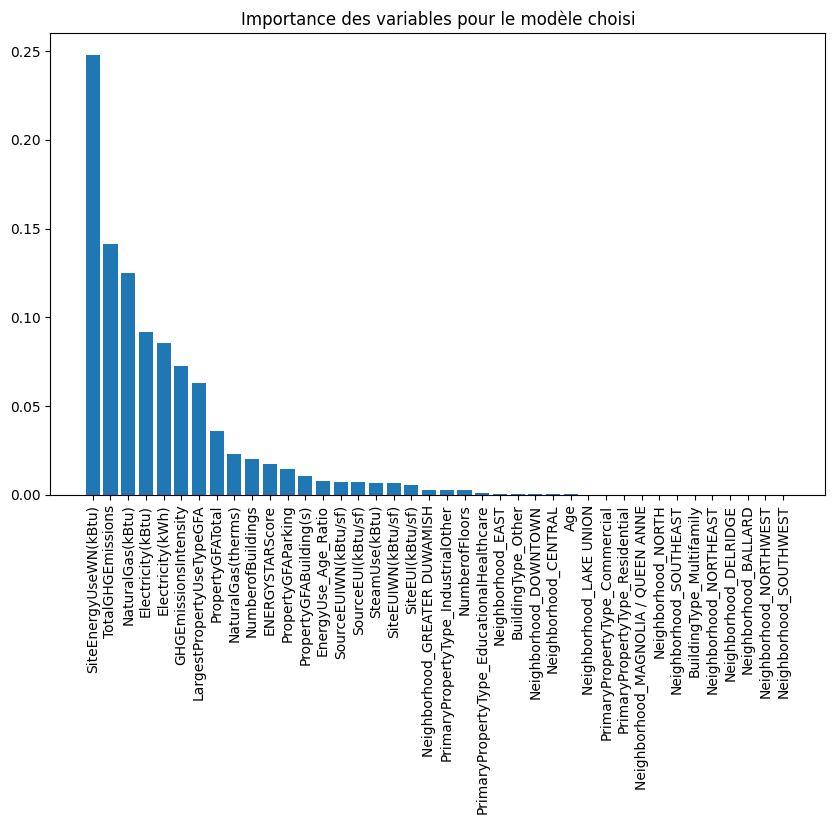

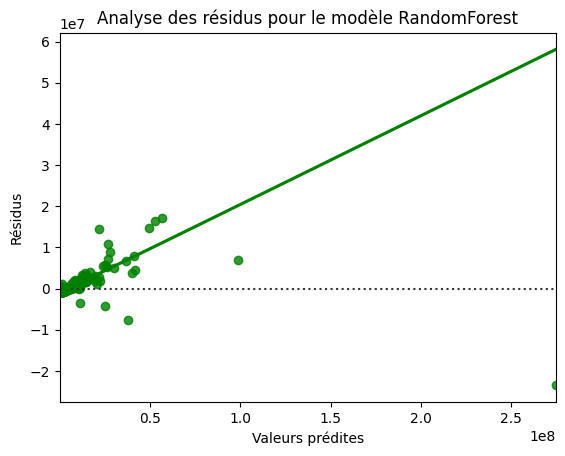

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

y_pred_rf = grid_search_rfr.best_estimator_.predict(X_test)

best_params = grid_search_gbr.best_params_

# Vous pouvez maintenant accéder aux meilleurs paramètres individuellement
# Par exemple :
n_estimators = best_params['n_estimators']
learning_rate = best_params['learning_rate']
max_depth = best_params['max_depth']
max_features = best_params['max_features']

# Puis recréer votre meilleur modèle en utilisant ces paramètres
best_gbr = GradientBoostingRegressor(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    max_features=max_features,
    random_state=42
)

# N'oubliez pas d'entraîner votre modèle
best_gbr.fit(X_train, y_train)

# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation de l'importance des variables pour le modèle choisi
feature_importances = grid_search_gbr.best_estimator_.feature_importances_
sorted_importances = sorted(zip(df.drop('SiteEnergyUse(kBtu)', axis=1).columns, feature_importances), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), [importance for _, importance in sorted_importances])
plt.xticks(range(len(sorted_importances)), [feature for feature, _ in sorted_importances], rotation=90)
plt.title("Importance des variables pour le modèle choisi")
plt.show()

# Analyse des résidus
sns.residplot(x=y_test, y=y_pred_rf, lowess=True, color="g")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Analyse des résidus pour le modèle RandomForest")
plt.show()

## Table de comparaison des meilleurs modèles
| Modèle | RSE | Temps d'entrainement | Taille du modèle | R² |
| --- | --- | --- | --- | --- |
| Régression linéaire | 0.000 | 0.000 | 0.000 | 0.000 |
| Random Forest Regressor | 0.000 | 0.000 | 0.000 | 0.000 |
| Gradient Boosting Regressor | 0.000 | 0.000 | 0.000 | 0.000 |

Créer une table de comparaison des modèles
 - RSE 
 - Temps d'entrainement 
 - Taille du modèle sur le disque avec pickle pour chacun des modèles

